# Regression on EU data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import copy
# import custom functions in myFunctions.ipynb
import ipynb.fs.defs.myFunctions as myFun

In [3]:
# load data
df = pd.read_pickle("Data/eu_2016_gnc_oecd")

In [5]:
df.head()

,city_gnc,gncAbs,gncRel,iso3,METRO_ID,city_oecd,population,gdp
0,London,113607,100.000000,GBR,UK001,London,12242903.0,826486.0
5,Paris,79971,70.392669,FRA,FR001,Paris,12821812.0,865380.0
12,Milan,67790,59.670619,ITA,IT002,Milan,4944254.0,295105.0
17,Frankfurt,63499,55.893563,DEU,DE005,Frankfurt am Main,2648379.0,182005.0
19,Madrid,60485,53.240557,ESP,ES001,Madrid,6675302.0,322055.0


In [5]:
"""
Try compare two regression models. There are only 17 data points. 
Let's trial run this, and then extend to Europe/US, where there is more data.  

Eventually we'll do two analysis: 
(A) OLS model selelection. Between  (where x = log pop, y = log gdp, z = log gnc)
    (1) traitional urban scaling model: y = beta x + c
    (2) model with connectivity : y = beta x + alpha z +  c
(B) Show residual in GDP is correlated with residual in GNC. 
"""

"\nTry compare two regression models. There are only 17 data points. \nLet's trial run this, and then extend to Europe/US, where there is more data.  \n\nEventually we'll do two analysis: \n(A) OLS model selelection. Between  (where x = log pop, y = log gdp, z = log gnc)\n    (1) traitional urban scaling model: y = beta x + c\n    (2) model with connectivity : y = beta x + alpha z +  c\n(B) Show residual in GDP is correlated with residual in GNC. \n"

## A. Build OLS models

## EU countries

In [6]:
EU_iso3 = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA",
           "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD",
           "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE", "GBR"]

# as of 2013
# according to : https://www.kaweb.co.uk/blog/list-eu-countries-and-iso-3166-1-alpha-3-code/           
           

In [7]:
eu = myFun.clean_data(df[df.iso3.isin(EU_iso3)], ["population", "gdp", "gncAbs"])

In [8]:
eu.head()

,city_gnc,gncAbs,gncRel,iso3,METRO_ID,city_oecd,population,gdp
0,London,113607,100.000000,GBR,UK001,London,12242903.0,826486.0
5,Paris,79971,70.392669,FRA,FR001,Paris,12821812.0,865380.0
12,Milan,67790,59.670619,ITA,IT002,Milan,4944254.0,295105.0
17,Frankfurt,63499,55.893563,DEU,DE005,Frankfurt am Main,2648379.0,182005.0
19,Madrid,60485,53.240557,ESP,ES001,Madrid,6675302.0,322055.0


In [9]:
# see what countries are in the data set. 
eu.iso3.unique()

array(['GBR', 'FRA', 'ITA', 'DEU', 'ESP', 'POL', 'NLD', 'BEL', 'IRL',
       'AUT', 'SWE', 'LUX', 'PRT', 'CZE', 'DNK', 'GRC', 'FIN', 'HUN',
       'SVK', 'EST', 'LVA', 'LTU', 'SVN'], dtype=object)

In [10]:
len(eu)

94

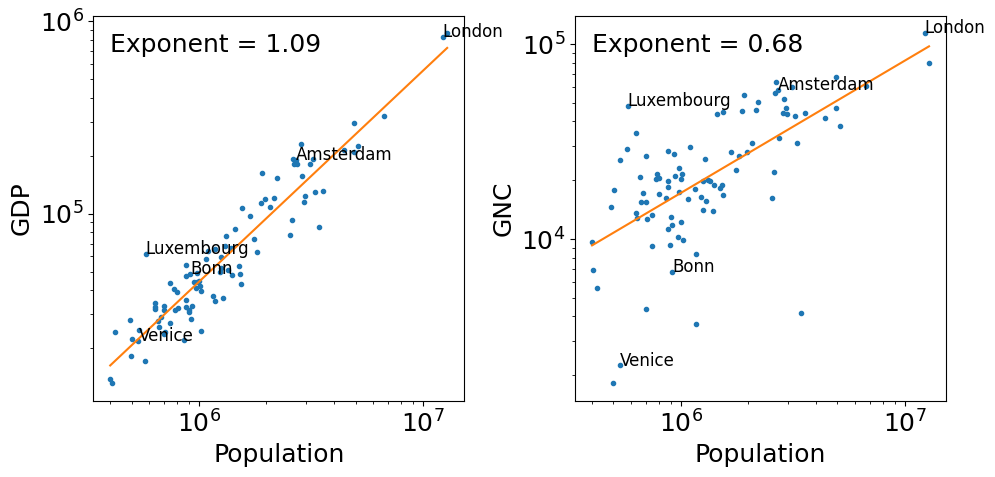

In [11]:

EUannotate = ["London", 
              "Venice",
               "Amsterdam", "Bonn",
               'Luxembourg', 
              ]

myFun.plot_descriptives(eu, "population", "gdp", "gncAbs", "city_gnc", EUannotate, "Population", "GDP", "GNC", dotmarker = ".")

In [13]:
# get correlation betwee population and gnc 
stats.pearsonr(np.log(eu.population), np.log(eu.gncAbs))

PearsonRResult(statistic=0.6522004192784749, pvalue=1.0726809826597163e-12)

In [14]:
def store_results(results):
    out = {"params": results.params, "aic": results.aic, "bic": results.bic, "CI95": results.conf_int(alpha = 0.05), 
          "r_sq": results.rsquared, "r_sq_adj": results.rsquared_adj, "standar_err": results.bse}
    return out 

def run_null_model(df, xvar, yvar):
    Y = np.log(df[yvar])
    X = np.log(df[xvar])
    X = sm.add_constant(X)
    
    model = sm.OLS(Y,X)
    results = model.fit()
    
    out = store_results(results)
        
    return out

def run_gnc_model(df, x1var, x2var, yvar):
    Y = np.log(df[yvar])
    X = np.log(df[[x1var, x2var]])
    X = sm.add_constant(X)
    
    model = sm.OLS(Y,X)
    results = model.fit()
    
    out = store_results(results)

    return out

In [18]:
# null model: log Y = beta log N + c
outEU1 = run_null_model(eu, "population", "gdp")
outEU1

{'params': const        -4.426508
 population    1.094873
 dtype: float64,
 'aic': 30.335724017169923,
 'bic': 35.42231358170993,
 'CI95':                    0         1
 const      -5.548884 -3.304131
 population  1.015365  1.174382,
 'r_sq': 0.8904743444639085,
 'r_sq_adj': 0.8892838482080814,
 'standar_err': const         0.565120
 population    0.040033
 dtype: float64}

In [19]:
# GNC model: log Y = beta log N + alpha log GNC + c. 
outEU2 = run_gnc_model(eu, "population", "gncAbs", "gdp")
outEU2

{'params': const        -4.504780
 population    0.955366
 gncAbs        0.205650
 dtype: float64,
 'aic': 13.873773640276966,
 'bic': 21.503657987086978,
 'CI95':                    0         1
 const      -5.528499 -3.481061
 population  0.859755  1.050977
 gncAbs      0.113728  0.297572,
 'r_sq': 0.9100049119577289,
 'r_sq_adj': 0.9080269979348219,
 'standar_err': const         0.515370
 population    0.048133
 gncAbs        0.046276
 dtype: float64}